In [2]:
import torchvision
import torch
import matplotlib.pyplot as plt

In [3]:
torchvision.__version__

'0.16.0+cu121'

In [4]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo -qqq
  from torchinfo import summary

In [5]:
try:
  from helper_functions import accuracy_fn
  from going_modular.going_modular import engine,model_builder
except:
  !git clone https://github.com/mrdbourke/pytorch-deep-learning.git
  !mv pytorch-deep-learning/helper_functions.py .
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from helper_functions import accuracy_fn
  from going_modular.going_modular import engine,model_builder

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 4056 (delta 1141), reused 1124 (delta 1124), pack-reused 2822
Receiving objects: 100% (4056/4056), 649.94 MiB | 27.76 MiB/s, done.
Resolving deltas: 100% (2386/2386), done.
Updating files: 100% (248/248), done.


<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png">

In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get Data

In [7]:
from helper_functions import download_data
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [8]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# create dataset and data loader

In [9]:
from torchvision import transforms
from going_modular.going_modular import data_setup
#from data_setup import create_dataloaders

img_size=224
batch_size=32

#create a transforms
manual_transform=transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor()
])
manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [10]:
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=batch_size
)
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a58bc6134f0>,
 ['pizza', 'steak', 'sushi'])

# visualize,visualize,visualize image



In [11]:
images,labels=next(iter(train_dataloader))
len(images),len(labels)
images[0].shape

torch.Size([3, 224, 224])

(-0.5, 223.5, 223.5, -0.5)

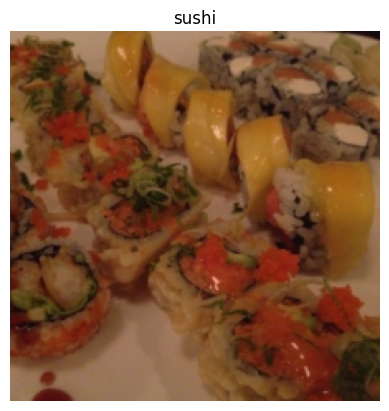

In [12]:
images,labels=next(iter(train_dataloader))
image,label=images[0],labels[0]
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("OFF")

# lets initialize the variables

In [13]:
height=224
width=224
color_channel=3
patch_size=16

number_of_patches=int(height*width/patch_size**2)

input_image_size=(height,width,color_channel)
output_image_size=(number_of_patches,patch_size**2*color_channel)
print(f"input channel {input_image_size}")
print(f"output channel {output_image_size}")

input channel (224, 224, 3)
output channel (196, 768)


# lets patchify a single image

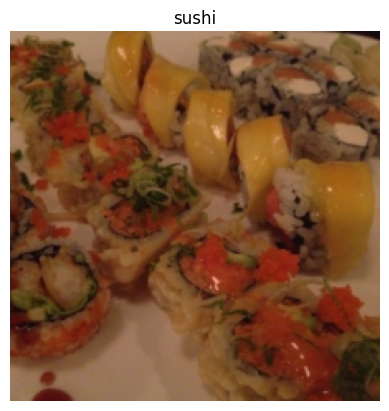

In [14]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("OFF");

In [15]:
image.shape

torch.Size([3, 224, 224])

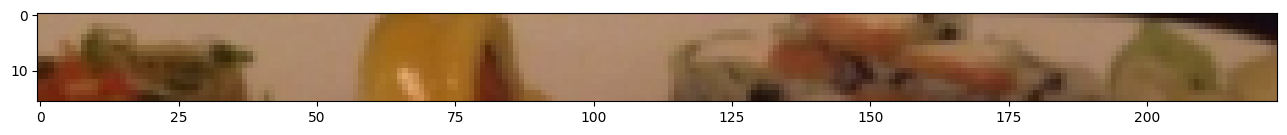

In [16]:
#lets display the image of a patch size
plt.figure(figsize=(patch_size,patch_size))
permuted_image=image.permute(1,2,0)
plt.imshow(permuted_image[:patch_size,:,:])
#plt.axis("off");

In [17]:
#permuted_image.shape
#print(len(ax)==num_patches)
permuted_image.dtype

torch.float32

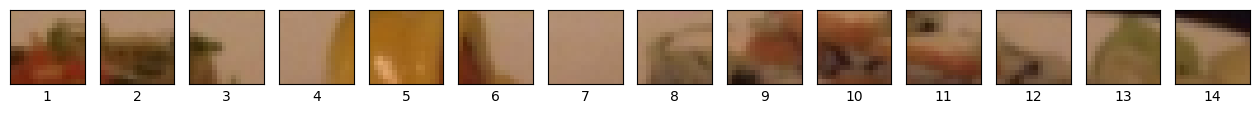

In [18]:
img_size=224
patch_size=16
num_patches=img_size/patch_size
assert img_size%patch_size==0,"image size must be divisible by patch size"

fig,ax=plt.subplots(nrows=1,
                    ncols=int(num_patches),
                    sharex=True,
                    sharey=True,
                    figsize=(patch_size,patch_size))

for i,patch in enumerate(range(0,img_size,patch_size)):
  ax[i].imshow(permuted_image[:patch_size,patch:patch+patch_size,:])  #this is along the height,width and color channels
  ax[i].set_xlabel(i+1)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

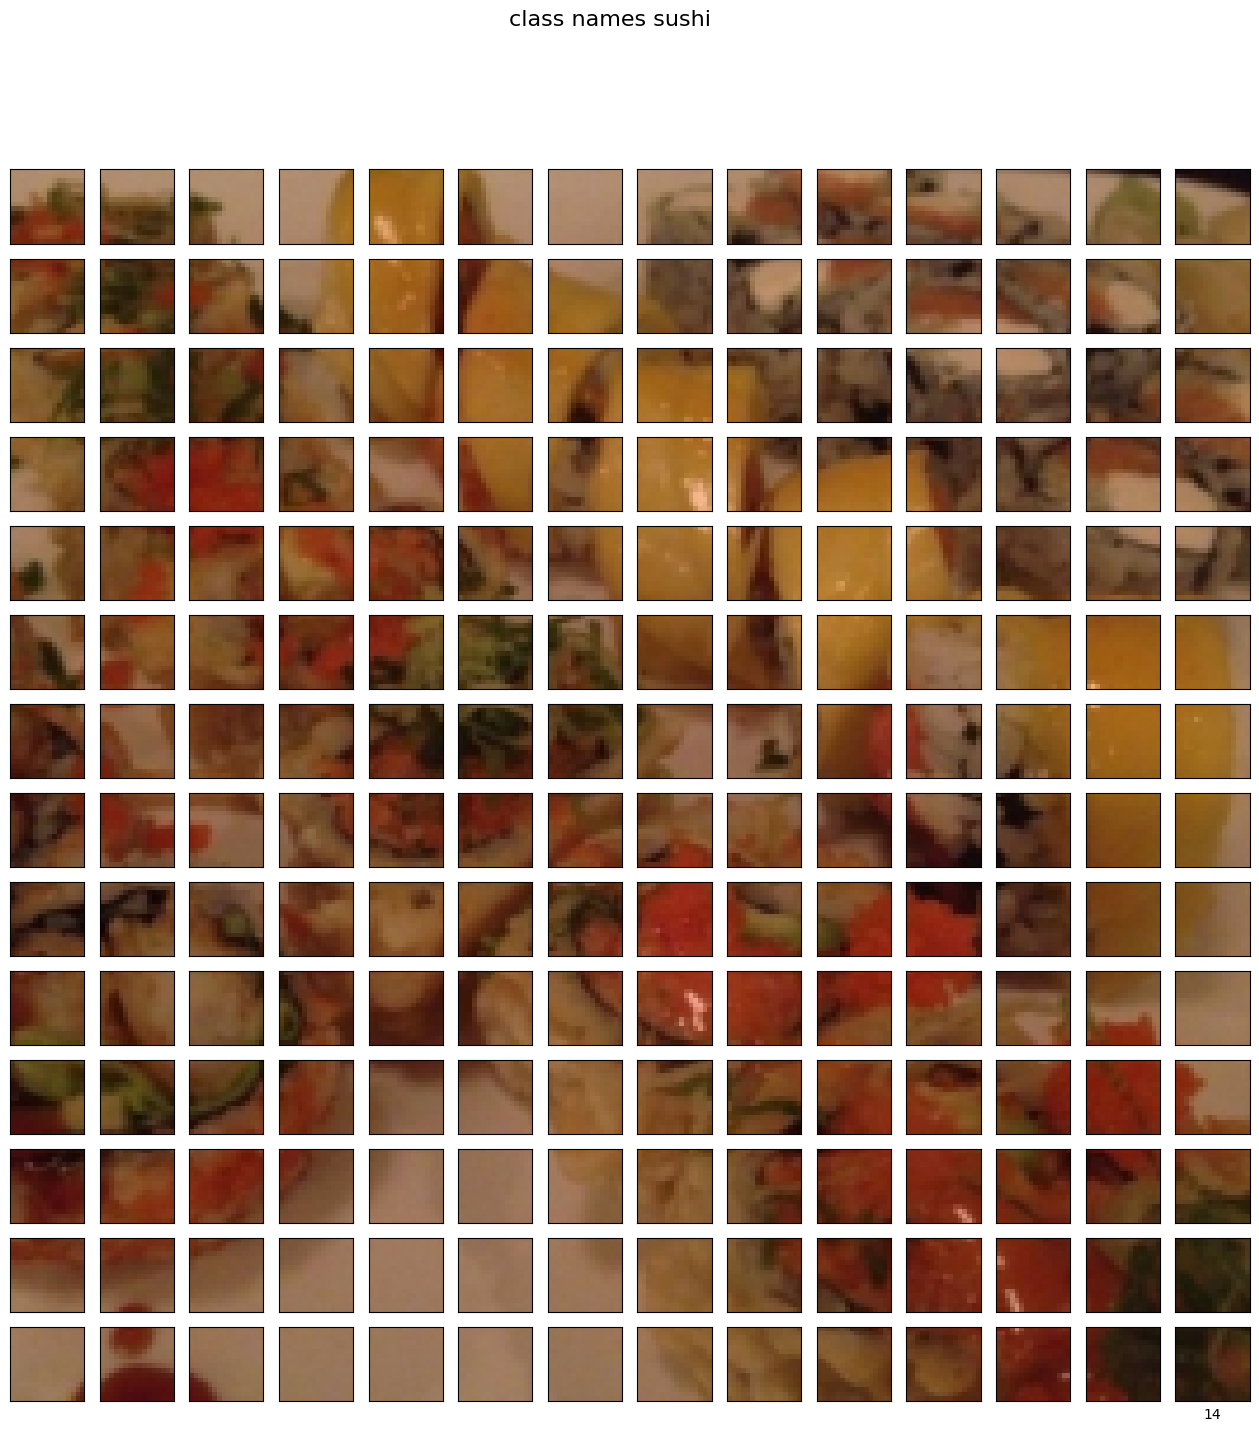

In [19]:
img_size=224
patch_size=16
num_patches=img_size/patch_size
assert img_size%patch_size==0,"image size must be divisible by patch size"

fig,ax=plt.subplots(nrows=int(num_patches),
                    ncols=int(num_patches),
                    sharex=True,
                    sharey=True,
                    figsize=(patch_size,patch_size))

for i,patch_height in enumerate(range(0,img_size,patch_size)):
  for j,patch_width in enumerate(range(0,img_size,patch_size)):
    ax[i,j].imshow(permuted_image[patch_height:patch_height+patch_size,
                                  patch_width:patch_width+patch_size,:])  #this is along the height,width and color channels

  ax[i,j].set_xlabel(j+1)
  ax[i,j].set_ylabel(i+1,
                     rotation="horizontal",
                     horizontalalignment="right",
                     verticalalignment="center")

  ax[i,j].set_xticks([])
  ax[i,j].set_yticks([])
  ax[i,j].label_outer()

fig.suptitle(f"class names {class_names[label]}",fontsize=16)
plt.show()

# creating an image patches and embedding the images
we will use kernel_size and stride as image_patch

In [20]:
from torch.nn import Conv2d

conv=Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size
)
conv

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [21]:
image_out_of_conv=conv(image.unsqueeze(dim=0))
print(f"the shape is: {image_out_of_conv.shape}")

the shape is: torch.Size([1, 768, 14, 14])


selected feature indexes [354, 420, 671, 71, 22]


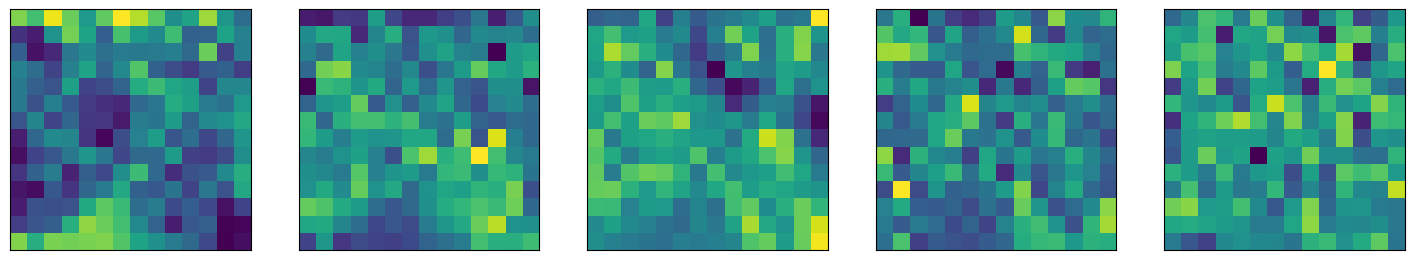

In [22]:
#plot some random features from convolution maps
import random
selected_feature_indexes=random.sample(range(0,758),k=5)   #value 758 is from subtracting 768 embedding by 10
print(f"selected feature indexes {selected_feature_indexes}")

fig,ax=plt.subplots(nrows=1,ncols=5,figsize=(18,15))

for i,idx in enumerate(selected_feature_indexes):
  image_feature=image_out_of_conv[:,idx,:,:]
  ax[i].imshow(image_feature.squeeze().detach().numpy())
  ax[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

# flatten the embedded image patches
* we want the shape of the images to be in format -> batch size,number of ebedding, feature height and feature width
* then after the flatten layer it should be -> number of patches,number of embeddings

In [23]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [24]:
import torch.nn as nn
flatten_layer=nn.Flatten(start_dim=2)
flatt_image=flatten_layer(image_out_of_conv)
flatt_image[0].shape

torch.Size([768, 196])

original image shape torch.Size([3, 224, 224])
after the embedding shape is torch.Size([1, 768, 14, 14])
shape after flatting is torch.Size([1, 768, 196])


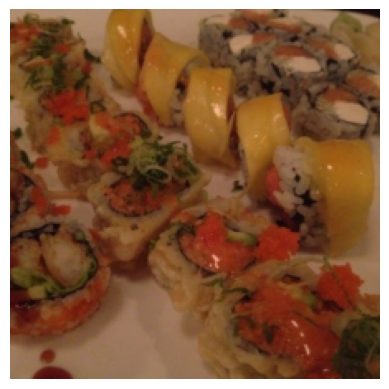

In [25]:
#all in one
plt.imshow(image.permute(1,2,0))
plt.axis("off")
print(f"original image shape {image.shape}")

#image after enbedding
image_out_of_embd=conv(image.unsqueeze(dim=0))
print(f"after the embedding shape is {image_out_of_embd.shape}")

#image after flatting layer
image_out_of_flatten=flatten_layer(image_out_of_embd)
print(f"shape after flatting is {image_out_of_flatten.shape}")

In [26]:
#the flatten layer should return
flatten_permute=image_out_of_flatten.permute(0,2,1)
flatten_permute.shape

torch.Size([1, 196, 768])

In [27]:
image.shape

torch.Size([3, 224, 224])

In [28]:
# # all in one
# def all_in_one(image,
#               patch_size:int=16):

#   n_patche=int(image.shape[1]*image.shape[2]/patch_size**2)
#   conv=torch.nn.Conv2d(in_channels=3,
#                        out_channels=768,
#                        kernel_size=patch_size,
#                        stride=patch_size)

#   image_after_conv=conv(image.unsqueeze(dim=0))
#   print(image_after_conv.shape)
#   #flatten layer
#   flatten_layer=torch.nn.Flatten(start_dim=2,
#                                  end_dim=-1)
#   flattened_conv_image=flatten_layer(image_after_conv)
#   print(flattened_conv_image.shape)
#   return flattened_conv_image

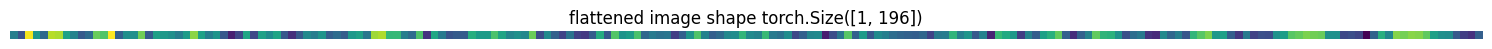

In [29]:
single_flatten_feature_map = flatten_permute[:, :, 0]
plt.figure(figsize=(19,19))
plt.imshow(single_flatten_feature_map.detach().numpy())
plt.axis(False);
plt.title(f"flattened image shape {single_flatten_feature_map.shape}");

In [30]:
# make a class for all the steps
class PatchEmbedding(nn.Module):
  def __init__(self,in_channels:int=3,
               embedding_dim:int=768,
               patch_size:int=16):
    super().__init__()

    #make a convolution layer
    self.patch=nn.Conv2d(
        in_channels=in_channels,
        out_channels=embedding_dim,
        kernel_size=patch_size,
        stride=patch_size
    )
    self.flatten_layer=nn.Flatten(
        start_dim=2,
        end_dim=-1
    )
  def forward(self,x):
    assert x.shape[-1]%patch_size==0,f"the image resolution must be divisible by the patch size.patch size is {patch_size} and image size is {x.shape[-1]}"
    self.patcher=self.patch(x)
    #print(f"after patching the image {self.patcher.shape}")
    self.flattened_image=self.flatten_layer(self.patcher)
    # the returned flattened image is of shape number of patches,embedding size
    #print(f"after flattening the image {self.flattened_image.shape}")
    #after permuting the flattened image
    self.permuted_flatten=self.flattened_image.permute(0,2,1)
    #print(f"after permuting flattened image {self.flattened_image.shape}")
    return self.permuted_flatten

In [31]:
embeder=PatchEmbedding(3,768)
print(f"input image shape is {image.shape}")
print(f"output shape is: {embeder.forward(image.unsqueeze(dim=0)).shape}")

input image shape is torch.Size([3, 224, 224])
output shape is: torch.Size([1, 196, 768])


In [32]:
patch_embeded_image=embeder(image.unsqueeze(dim=0))
print(f"shape is {patch_embeded_image.shape}")
print(patch_embeded_image)

shape is torch.Size([1, 196, 768])
tensor([[[ 0.1396,  0.2189,  0.3304,  ..., -0.2816,  0.0562, -0.0250],
         [ 0.0249,  0.1967,  0.3582,  ..., -0.2113,  0.0398,  0.0037],
         [ 0.0758,  0.3903,  0.4141,  ..., -0.3230, -0.0611, -0.0544],
         ...,
         [ 0.2223,  0.2597,  0.1927,  ..., -0.2338, -0.0165, -0.1062],
         [ 0.1516,  0.1103,  0.1431,  ..., -0.0685, -0.0216, -0.0479],
         [ 0.0648,  0.1865,  0.1490,  ..., -0.0988, -0.0590, -0.1039]]],
       grad_fn=<PermuteBackward0>)


In [33]:
#lets make a good and bad data
good_image=torch.randn(1,3,224,224)
bad_image=torch.randn(1,3,225,225)

In [34]:
temp=PatchEmbedding()
temp(good_image)

tensor([[[-0.1373,  0.4414,  0.3263,  ...,  0.3592, -0.7686,  0.4849],
         [-0.3431,  0.1651,  0.7463,  ...,  0.0249, -0.5947,  1.2410],
         [-0.3379, -0.0709, -0.1478,  ...,  0.1450,  0.4669,  0.1193],
         ...,
         [ 0.0591, -0.3867,  0.1149,  ...,  0.0364,  0.1777, -0.0615],
         [ 0.3997,  0.2850,  0.4741,  ..., -1.1522, -0.4447,  0.2157],
         [ 0.0292,  0.0309,  0.4723,  ...,  0.1416,  0.0436,  0.2528]]],
       grad_fn=<PermuteBackward0>)

### demonstrating that the assertion work

In [35]:
# temp(bad_image)

# class token embedding

In [36]:
#making a class token that has the same dimension as the token embedding
batch_size=patch_embeded_image.shape[0]
embed_size=patch_embeded_image.shape[-1]

class_token=nn.Parameter(
    data=torch.ones(batch_size,1,embed_size),
    requires_grad=True
)
print(class_token.shape)

torch.Size([1, 1, 768])


In [37]:
patch_embeded_image.shape

torch.Size([1, 196, 768])

In [38]:
#adding this to the already existing patches
embeded_patches_with_class_embedding=torch.cat((class_token,patch_embeded_image),dim=1)  #one is the number of patchese dimension
print(embeded_patches_with_class_embedding.shape)
print(embeded_patches_with_class_embedding)

torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.1396,  0.2189,  0.3304,  ..., -0.2816,  0.0562, -0.0250],
         [ 0.0249,  0.1967,  0.3582,  ..., -0.2113,  0.0398,  0.0037],
         ...,
         [ 0.2223,  0.2597,  0.1927,  ..., -0.2338, -0.0165, -0.1062],
         [ 0.1516,  0.1103,  0.1431,  ..., -0.0685, -0.0216, -0.0479],
         [ 0.0648,  0.1865,  0.1490,  ..., -0.0988, -0.0590, -0.1039]]],
       grad_fn=<CatBackward0>)


# creating position embedding

In [39]:
embeded_patches_with_class_embedding.shape

torch.Size([1, 197, 768])

In [40]:
batch_size=1
number_of_patches=int((height*width)/patch_size**2)
embedding_size=embeded_patches_with_class_embedding.shape[-1]

position_embedding=nn.Parameter(
    data=torch.ones(batch_size,
                    number_of_patches+1,
                    embedding_size),
    requires_grad=True
)
embed_patch_class_position=embeded_patches_with_class_embedding+position_embedding
print(embed_patch_class_position.shape)

torch.Size([1, 197, 768])


In [41]:
# class encoder(nn.Module):
#   def __init__(self,images):
#     super().__init__()
#     patchify=PatchEmbedding()
#     xps=patchify.forward(image)
#     xclass=nn.Parameter(
#         data=torch.randn(image.shape[0],
#                          xps.shape[1],
#                          xps.shape[2]),
#         requires_grad=True
#     )
#     position_emb=nn.Parameter(
#         data=torch.randn(image.shape[0],
#                          xps.shape[1]+1,
#                          xps.shape[2]),
#         requires_grad=True
#     )
#     image_embeded_class=torch.cat((xclass,xps),dim=1)
#     image_embeded_class_position=image_embeded_class+position_emb

# going from image into embedding(then flattening it)

In [42]:
#all in one steps using an image
height,width=image.shape[1],image.shape[2]
patch_size=16

#lets a batch size parameter to the data
x=image.unsqueeze(dim=0)

patchifier=PatchEmbedding(
    in_channels=3,
    embedding_dim=768,
    patch_size=patch_size
)

image_patchified=patchifier(x)
print(image_patchified.shape)

batch_size=image_patchified.shape[0]
embedding_dim=image_patchified.shape[-1]

extra_learnable=nn.Parameter(
    data=torch.ones(batch_size,
                    1,
                    embedding_dim
                    ),
    requires_grad=True
)
print(f"out class token or learnable parameter has {extra_learnable.shape}")
#lets add the extra learnable class
image_embeded_learnable_class=torch.cat((extra_learnable,image_patchified),dim=1)
print(f"shape after the learnable class added {image_embeded_learnable_class.shape}")

number_of_patches=int((height*width)/patch_size**2)

#lets add the position embedding on the last position
position_embedding=nn.Parameter(
    data=torch.ones(1,
                    number_of_patches+1,
                    embedding_dim),
    requires_grad=True
)
#adding position embedding to the image emeded class
image_embeded_class_position=image_embeded_learnable_class+position_embedding
print(f"image after the position class embedding {image_embeded_class_position.shape}")

torch.Size([1, 196, 768])
out class token or learnable parameter has torch.Size([1, 1, 768])
shape after the learnable class added torch.Size([1, 197, 768])
image after the position class embedding torch.Size([1, 197, 768])


# lets introduce MultiHead self attention

In [43]:
#use multihead self attention
class multihead_block(nn.Module):
  def __init__(self,
               embed_dim:int=768,
               num_heads:int=12,
               drop_out:float=0.0):
    super().__init__()
    self.layer_norm=nn.LayerNorm(embed_dim)
    self.multihead=nn.MultiheadAttention(embed_dim=embed_dim,
                                         num_heads=num_heads,
                                         batch_first=True)
  def forward(self,x):
    normalized=self.layer_norm(x)
    attn_out,_=self.multihead(query=normalized,
                                           key=normalized,
                                           value=normalized,
                                           need_weights=False
                                           )
    return attn_out

In [44]:
#patches image through the MSA
multi_head=multihead_block(embed_dim=768,
                           num_heads=12,
                           )
image_through_msa=multi_head(image_embeded_class_position)
print(f"input shape of the msa is {image_embeded_class_position.shape}")
print(f"shape of image after the msa: {image_through_msa.shape}")

input shape of the msa is torch.Size([1, 197, 768])
shape of image after the msa: torch.Size([1, 197, 768])


In [45]:
image_embeded_class_position

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0527, 0.7509, 0.9743,  ..., 0.7934, 0.8392, 1.2419],
         [1.0851, 0.7480, 1.0074,  ..., 0.8042, 0.8678, 1.1925],
         ...,
         [1.0072, 0.7707, 0.9543,  ..., 0.8820, 0.8729, 1.2160],
         [1.0301, 0.8767, 1.0253,  ..., 0.8833, 0.9355, 1.0843],
         [1.0496, 0.8786, 1.0258,  ..., 0.9320, 0.8631, 1.1101]]],
       grad_fn=<AddBackward0>)

In [46]:
image_through_msa.shape

torch.Size([1, 197, 768])

In [47]:
class mlp_block(nn.Module):
  def __init__(self,
               input_size:int=768,  #which is the embeding dimension
               mlp_size:int=3072,
               drop_out:float=0.1
               ):
    super().__init__()

    #this is the layer norm
    self.norm_layer=nn.LayerNorm(normalized_shape=input_size)   #must of the input shape

    #this is the MLP layers
    self.layer=nn.Sequential(
        nn.Linear(in_features=input_size,
                  out_features=mlp_size),

        nn.GELU(),
        nn.Dropout(p=drop_out),

        nn.Linear(in_features=mlp_size,
                  out_features=input_size),
        nn.Dropout(p=drop_out)
    )

  def forward(self,x):
    norm=self.norm_layer(x)
    return self.layer(norm)

In [48]:
#lets see what happens after the image passes through the multi layer perceptron
mlp_object=mlp_block()
image_through_mlp=mlp_object(image_through_msa)
print(f"shape of patched image after MLH or the input block {image_through_msa.shape}")
print(f"shape of patched image after the MLP or the output block {image_through_mlp.shape}")

shape of patched image after MLH or the input block torch.Size([1, 197, 768])
shape of patched image after the MLP or the output block torch.Size([1, 197, 768])


In [49]:
print(image_through_msa)

tensor([[[-0.3531,  0.2856,  0.0893,  ...,  0.3774,  0.0228, -0.1282],
         [-0.3478,  0.2877,  0.0894,  ...,  0.3791,  0.0237, -0.1260],
         [-0.3479,  0.2859,  0.0905,  ...,  0.3773,  0.0236, -0.1261],
         ...,
         [-0.3502,  0.2912,  0.0884,  ...,  0.3796,  0.0234, -0.1257],
         [-0.3523,  0.2908,  0.0897,  ...,  0.3778,  0.0225, -0.1235],
         [-0.3502,  0.2897,  0.0880,  ...,  0.3791,  0.0228, -0.1271]]],
       grad_fn=<TransposeBackward0>)


In [50]:
print(image_through_mlp)

tensor([[[ 0.1784, -0.4382,  0.2531,  ..., -0.4580,  0.0089, -0.0692],
         [ 0.3066, -0.3694,  0.4009,  ..., -0.5395,  0.0000, -0.0000],
         [ 0.0000, -0.3678,  0.3194,  ..., -0.3522,  0.0235, -0.0000],
         ...,
         [ 0.2617, -0.3854,  0.3329,  ..., -0.4634, -0.0000, -0.2802],
         [ 0.2568, -0.2969,  0.0000,  ..., -0.5389,  0.0015, -0.2416],
         [ 0.2885, -0.2392,  0.1303,  ..., -0.0000, -0.0953, -0.1129]]],
       grad_fn=<MulBackward0>)


# encoder

In [51]:
class TransformerEncoder(nn.Module):
  def __init__(self,embeding_size:int=768,
               num_heads:int=12,
               mlp_size:int=3078,
               drop_out:float=0.1):
    super().__init__()
    self.multi_head=multihead_block(embed_dim=embedding_size,
                                    num_heads=num_heads,
                                    drop_out=drop_out)
    self.mlp=mlp_block(input_size=embeding_size,
                       mlp_size=mlp_size,
                      drop_out=drop_out)

  def forward(self,x):
    residual_1=self.multi_head(x)+x
    residual_2=self.mlp(residual_1)+residual_1
    return residual_2

In [52]:
model=TransformerEncoder()
summary(model=model,
        input_size=(1,197,768),
        col_width=20,
        col_names=["input_size","output_size","num_params","trainable"],
        row_settings=["var_names"]
        )

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)       [1, 197, 768]        [1, 197, 768]        --                   True
├─multihead_block (multi_head)                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                 [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead)         --                   [1, 197, 768]        2,362,368            True
├─mlp_block (mlp)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                 [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (layer)                     [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                        [1, 197, 768]        [1, 197, 3078]  

# built in pytorch transformer encoder layer

In [53]:
#lets built the model
transformer_encoder=nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
)

In [54]:
summary(model=transformer_encoder,
        input_size=(1,197,768),
        col_width=20,
        col_names=["input_size","output_size","num_params","trainable"],
        row_settings=["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# lets create the VIT model

In [55]:
class VitModel(nn.Module):
  def __init__(self,
               img_size:int=224,
               patch_size:int=16,
               num_class:int=100,
               in_channels:int=3,
               embedding_dim:int=768,
               num_heads:int=12,
               num_encoders:int=16,
               mlp_size:int=3072,
               dropout_embd:float=0.0,
               dropout_mlp:float=0.1
               ):

    super().__init__()
    assert img_size%patch_size==0, f"not compatible image size... is {img_size} and patch size is {patch_size}"
    num_patches=int(img_size*img_size//patch_size**2)

    self.patcher=PatchEmbedding(in_channels=in_channels,
                                embedding_dim=embedding_dim,
                                patch_size=patch_size)  #lets initiate the class object

    #lets add the extra learnable parameter
    self.learnable_class=nn.Parameter(data=torch.randn(
        1,
        1,
        embedding_dim,
    ),
    requires_grad=True)

    #lets add position embedding
    self.position=nn.Parameter(data=torch.randn(1,num_patches+1,embedding_dim),
                               requires_grad=True)

    self.norm=nn.LayerNorm(normalized_shape=embedding_dim)

    self.encoder_layers=nn.Sequential(*[TransformerEncoder(embeding_size=embedding_dim,
                                    num_heads=num_heads,
                                    mlp_size=mlp_size) for _ in range(num_encoders)],
                                   )
    #lets add the embedding drop out
    self.dropout=nn.Dropout(p=dropout_embd)

    #add the classifier layer into the layrs
    self.classifier=nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                   out_features=num_class)
    )
  def forward(self,x):
    #image into patches
    image_patch=self.patcher(x)

    #add learnable class into the patches
    batch_size=x.shape[0]
    image_class=self.learnable_class.expand(batch_size,-1,-1)
    image_patch_class=torch.cat((image_class,image_patch),dim=1)

    #lets add positional embedding
    image_patch_position=self.position+image_patch_class

    #lets add dropout into the dropout layer
    image_patch_class_droped=self.dropout(image_patch_position)

    #lets add this into the encoder layer
    result=self.encoder_layers(image_patch_class_droped)
    #lets add this into the classifier layer
    result=self.classifier(result[:,0])  #for every element in a batch access the 0th index
    return result

# visual summary of out model

In [56]:
#initiate the model
from torchinfo import summary
device="cuda" if torch.cuda.is_available() else "cpu"

vit=VitModel(num_class=3).to(device)
summary(model=vit,
         input_size=(32,3,224,224),
         col_names=["input_size",
                    "output_size",
                    "num_params",
                    "trainable"],
         col_width=20)

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VitModel                                      [32, 3, 224, 224]    [32, 3]              153,600              True
├─PatchEmbedding: 1-1                         [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d: 2-1                            [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten: 2-2                           [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout: 1-2                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential: 1-3                             [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoder: 2-3                [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─multihead_block: 3-1              [32, 197, 768]       [32, 197, 768]      

### !!! Experiment time

In [57]:
#experiment time for the model
random_image_tensor=torch.randn(1,3,224,224).to(device)

vit(random_image_tensor)

tensor([[ 0.1870,  0.7562, -0.6225]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

# training the VIT model

In [58]:
vit_model=VitModel(num_class=3).to(device)

In [59]:
from going_modular.going_modular import engine
optimizer=torch.optim.Adam(params=vit_model.parameters(),
                           lr=1e-3,
                           weight_decay=0.03,
                           )
loss_fn=nn.CrossEntropyLoss()
num_epochs=10

result=engine.train(model=vit_model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=num_epochs,
              device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.1226 | train_acc: 0.3203 | test_loss: 1.1207 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.5766 | train_acc: 0.3008 | test_loss: 1.0581 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1825 | train_acc: 0.2734 | test_loss: 1.1244 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.3334 | train_acc: 0.4102 | test_loss: 1.7151 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.7827 | train_acc: 0.3320 | test_loss: 2.6757 | test_acc: 0.5417
Epoch: 6 | train_loss: 2.0013 | train_acc: 0.4062 | test_loss: 1.4719 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.5117 | train_acc: 0.2656 | test_loss: 1.6243 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1919 | train_acc: 0.4102 | test_loss: 1.0099 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.2201 | train_acc: 0.2656 | test_loss: 1.3413 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1797 | train_acc: 0.3984 | test_loss: 2.5414 | test_acc: 0.1979


In [60]:
!nvidia-smi

Tue Feb 27 12:43:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              40W /  70W |   8391MiB / 15360MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# lets plot the accuracy of the model

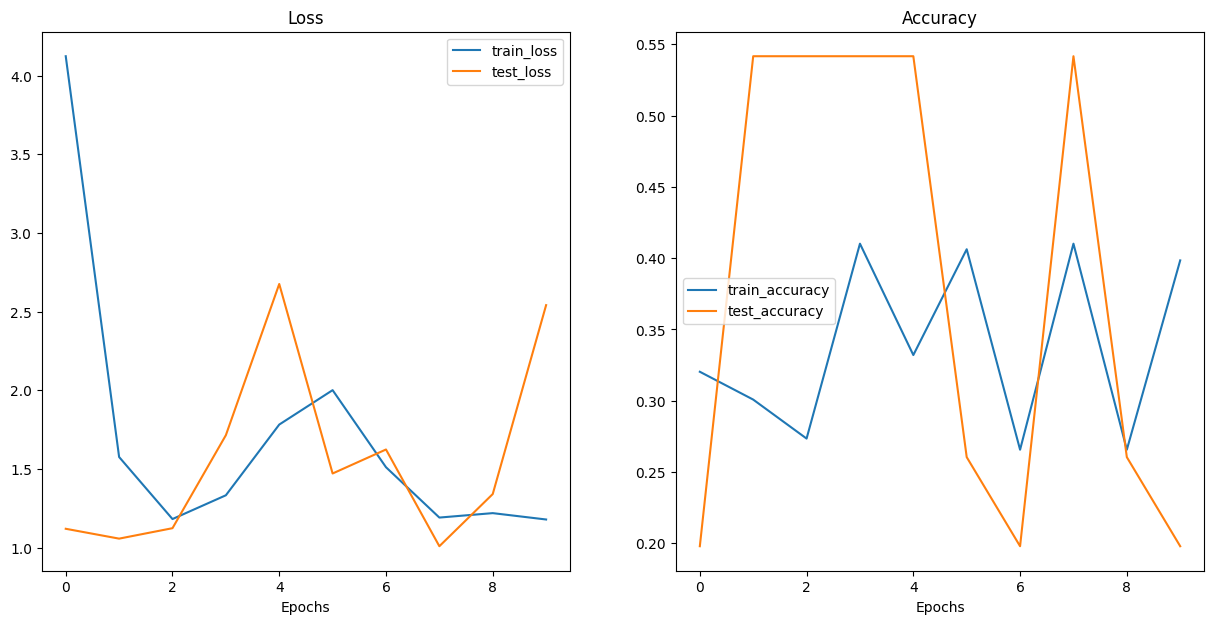

In [61]:
from helper_functions import plot_loss_curves
plot_loss_curves(result)

# lets try using transfer learning for VIT Model

In [82]:
#lets load the weights
import torchvision
weights=torchvision.models.ViT_B_16_Weights.DEFAULT
trained_model=torchvision.models.vit_b_16(weights=weights)

In [84]:
#freeze the parameter
for params in trained_model.parameters():
  params.requires_grad=False

#update the head of the model with our custom label
trained_model.heads=nn.Sequential(
    nn.Linear(in_features=768,
              out_features=len(class_names)
              )
).to(device)

In [85]:
#initiate the model
from torchinfo import summary
device="cuda" if torch.cuda.is_available() else "cpu"
summary(model=trained_model,
         input_size=(1,3,224,224),
         col_names=["input_size",
                    "output_size",
                    "num_params",
                    "trainable"],
         col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [86]:
def set_seed(seed:int=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

# lets train our transfer learning model

In [88]:
#lets prepare our dataset with the transform
import os
from going_modular.going_modular import data_setup
from going_modular.going_modular import engine

optimizer=torch.optim.Adam(params=trained_model.parameters(),
                      lr=1e-3)

loss_fn=nn.CrossEntropyLoss()
num_workers=os.cpu_count()
automatic_transform=weights.transforms()
batch_size=32
num_epochs=10

train_dataloader_trained,test_dataloader_trained,class_names=data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transform,
    batch_size=batch_size,
    num_workers=num_workers
)
#lets train our model
result=engine.train(model=trained_model,
                    train_dataloader=train_dataloader_trained,
                    test_dataloader=test_dataloader_trained,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=num_epochs,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7468 | train_acc: 0.7422 | test_loss: 0.4841 | test_acc: 0.8883
Epoch: 2 | train_loss: 0.3360 | train_acc: 0.9297 | test_loss: 0.3382 | test_acc: 0.8580
Epoch: 3 | train_loss: 0.2445 | train_acc: 0.9609 | test_loss: 0.2659 | test_acc: 0.8778
Epoch: 4 | train_loss: 0.1588 | train_acc: 0.9727 | test_loss: 0.2007 | test_acc: 0.9479
Epoch: 5 | train_loss: 0.1411 | train_acc: 0.9648 | test_loss: 0.1836 | test_acc: 0.9479
Epoch: 6 | train_loss: 0.1130 | train_acc: 0.9688 | test_loss: 0.1749 | test_acc: 0.9479
Epoch: 7 | train_loss: 0.1027 | train_acc: 0.9805 | test_loss: 0.1752 | test_acc: 0.9479
Epoch: 8 | train_loss: 0.0849 | train_acc: 0.9883 | test_loss: 0.1777 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.0710 | train_acc: 0.9883 | test_loss: 0.1810 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.1566 | train_acc: 0.8672 | test_loss: 0.1900 | test_acc: 0.9489


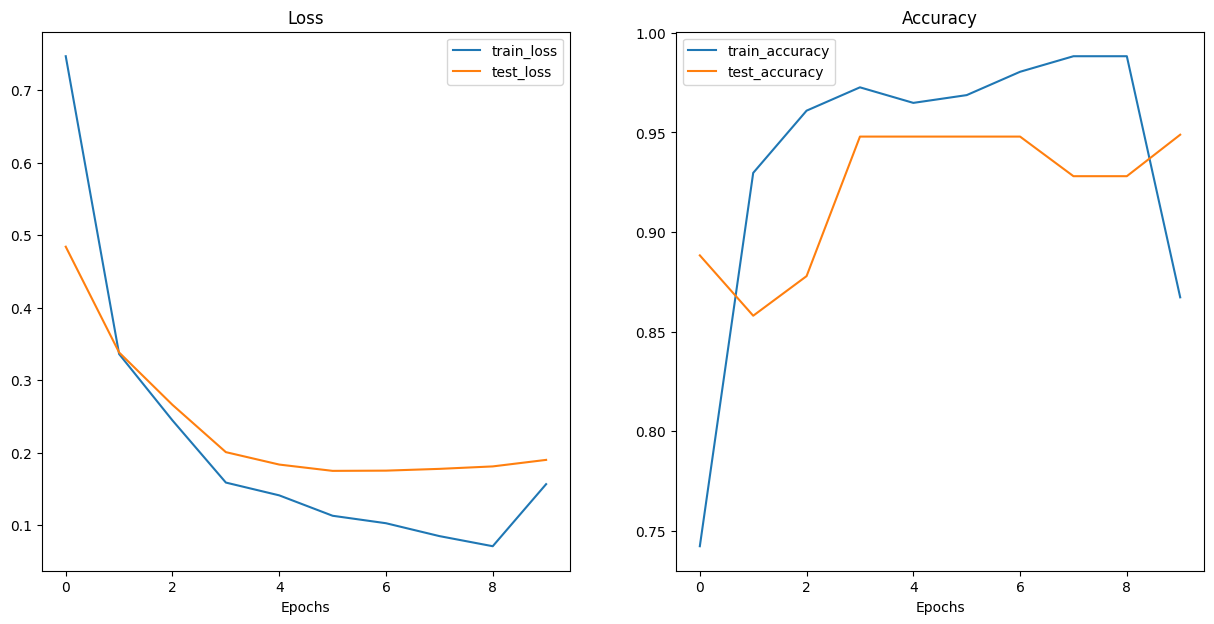

In [89]:
#plot the result of the fintunned(transfer learning)
plot_loss_curves(result)

# save the model

In [90]:
from going_modular.going_modular import utils
utils.save_model(model=trained_model,
                 target_dir="models",
                 model_name="vit_fintunned_for_food.pth")

[INFO] Saving model to: models/vit_fintunned_for_food.pth


#load the model and check its size

In [95]:
from pathlib import Path
saved_model_size=Path("models/vit_fintunned_for_food.pth").stat().st_size//(1024*1024)
print(f"the model size is {saved_model_size}MB")

the model size is 327MB


# predicting on custom image

data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


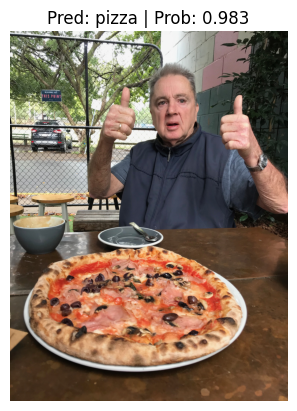

In [108]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=trained_model,
                    image_path=custom_image_path,
                    class_names=class_names)